## Seminar 4: Recommendations analysis

In [177]:
from typing import Tuple, List
from tqdm import tqdm
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

import gdown
import zipfile

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender, BM25Recommender, bm25_weight

### 1. Download dataset

Today we will use Amazon dataset for phones and accessories.

In [ ]:
# !pip install gdown

In [2]:
file_id = '17ogaNm1UiBabfRH9EdSXZTg1rPTvBft6'
destination = 'amazon.zip'
download_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(download_url, destination, quiet=False)

In [3]:
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('amazon')

### 2. EDA

In [4]:
ratings = pd.read_csv(
    "amazon/Amazon_Cell_Phones_and_Accessories/Amazon_Cell_Phones_and_Accessories.inter", 
    sep='\t', 
    names=["user_id", "item_id", "rating", "ts"],
    header=0
).sample(100_000).reset_index(drop=True)

In [5]:
ratings.head()

,user_id,item_id,rating,ts
0,AGYJ3XGIMCKNHCGMRKBQSY22ORKQ,B012ZN3JKC,5.0,1464110237000
1,AE7RDUZ47NZHWDPMFTHCIAUJEJCQ,B0BBW79P41,1.0,1671222402918
2,AERAWSA4GFE3EUCXKTGVJXR57ZWQ,B00OZCUOGY,5.0,1445008976000
3,AHAGAK4SBWRRR5M2NOS65XXHRI7A,B09P4ZMY2K,5.0,1642105749187
4,AGIZPS3DOIEV5PUFAFVBQFIKOSYA,B0832H8KNL,1.0,1605923412966


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  100000 non-null  object 
 1   item_id  100000 non-null  object 
 2   rating   100000 non-null  float64
 3   ts       100000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [7]:
items_data = pd.read_csv(
    "amazon/Amazon_Cell_Phones_and_Accessories/Amazon_Cell_Phones_and_Accessories.item", 
    sep='\t', 
    names=["item_id", "categories", "average_rating", "rating_number", "price"],
    header=0
)

In [8]:
items_data.head()

,item_id,categories,average_rating,rating_number,price
0,B013SK1JTY,"Cell Phones & Accessories,Cases, Holsters & Sl...",3.8,5,NaN
1,B07ZPSG8P5,"Cell Phones & Accessories,Cases, Holsters & Sl...",4.4,177,11.98
2,B00GKR3L12,"Cell Phones & Accessories,iPhone Accessories",4.0,2,NaN
3,B00PB8U8BW,"Cell Phones & Accessories,iPhone Accessories",4.0,15,NaN
4,B07D3RHSRV,"Cell Phones & Accessories,Cases, Holsters & Sl...",4.0,1,NaN


In [9]:
items_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288441 entries, 0 to 1288440
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   item_id         1288441 non-null  object 
 1   categories      1288441 non-null  object 
 2   average_rating  1288441 non-null  float64
 3   rating_number   1288441 non-null  int64  
 4   price           252090 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 49.2+ MB


In [10]:
joined = pd.merge(ratings, items_data, on="item_id", how="inner")

In [11]:
def ids_encoder(ratings, items_data):

    ratings['user_id'] = ratings['user_id'].astype(str)
    ratings['item_id'] = ratings['item_id'].astype(str)
    items_data['item_id'] = items_data['item_id'].astype(str)
    
    users = sorted(ratings['user_id'].unique())
    items = sorted(ratings['item_id'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    items_data = items_data[items_data['item_id'].isin(iencoder.classes_)]

    # encode userids and itemids
    ratings.user_id = uencoder.transform(ratings.user_id.tolist())
    ratings.item_id = iencoder.transform(ratings.item_id.tolist())
    items_data.item_id = iencoder.transform(items_data.item_id.tolist())

    return ratings, items_data, uencoder, iencoder

ratings, items_data, uencoder, iencoder = ids_encoder(ratings, items_data)

/var/folders/0z/3w0j3xd529qf_7fc2w5t19nm3wgh24/T/ipykernel_21048/3028391399.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_data.item_id = iencoder.transform(items_data.item_id.tolist())


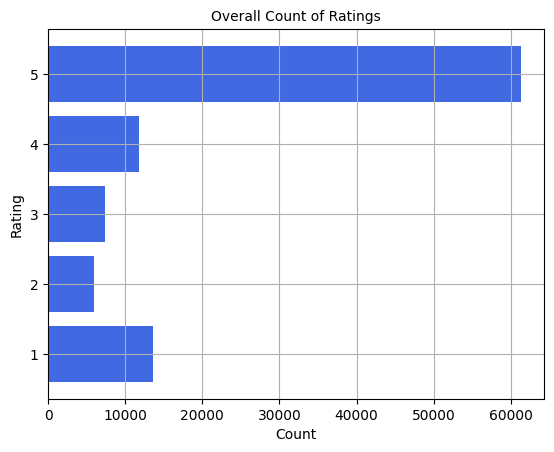

In [12]:
ratings_cnt = ratings.groupby('rating')['user_id'].count().rename('cnt_users').reset_index()
plt.barh(ratings_cnt.rating, ratings_cnt.cnt_users, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=10)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid()
plt.show()

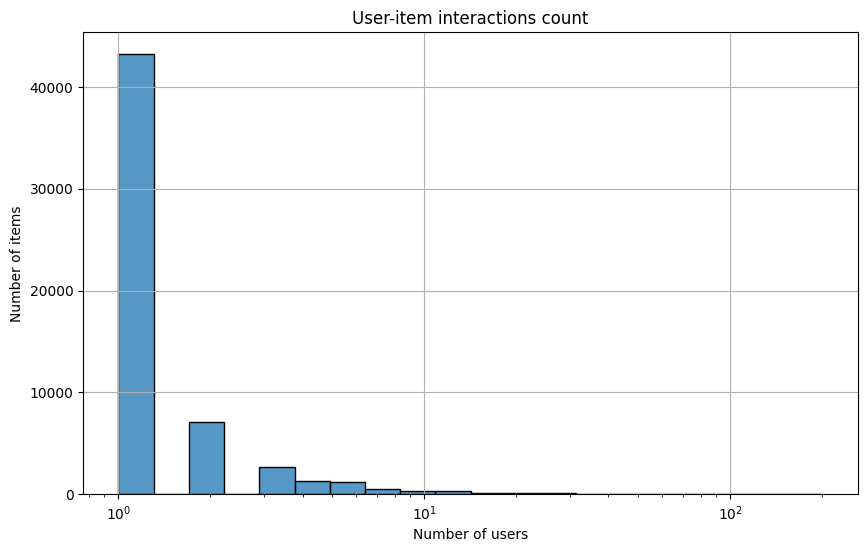

In [132]:
user_item_counts = ratings.groupby('item_id')['user_id'].count().values

# Plot the histogram
plt.figure(figsize=(10, 6))
ax = sns.histplot(user_item_counts, bins=20, log_scale=True);
ax.set(xlabel="Number of users", ylabel="Number of items", title='User-item interactions count')
ax.grid()

### 3. Fit algorithms

Firstly, let's create csr matrix and user, item mappings.

In [123]:
def get_coo_matrix(interactions, 
                   users_mapping, 
                   items_mapping,
                   user_col='user_id', 
                   item_col='item_id', 
                   weight_col=None):
    if weight_col is None:
        weights = np.ones(len(interactions), dtype=np.float32)
    else:
        weights = interactions[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            interactions[user_col].map(users_mapping.get), 
            interactions[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

def make_mapping(data):
    return dict([(v, k) for k, v in enumerate(data)])

In [124]:
items_mapping = make_mapping(items_data['item_id'].unique())
users_mapping = make_mapping(ratings['user_id'].unique())

items_inv_mapping = dict({(v, k) for k, v in items_mapping.items()})

In [125]:
interactions_matrix = get_coo_matrix(ratings, 
                                     users_mapping=users_mapping, 
                                     items_mapping=items_mapping).tocsr()

[1. 1. 1. ... 1. 1. 1.]


In [88]:
interactions_matrix_f64 = interactions_matrix.astype('float64')

#### i2i model

In [83]:
i2i_model = ItemItemRecommender(K=10)
i2i_model.fit(interactions_matrix_f64) 

  0%|          | 0/56935 [00:00<?, ?it/s]

In [110]:
top_n = 50
total_preds_i2i = {}
for user in ratings['user_id'].unique():
    preds = i2i_model.recommend(user, interactions_matrix[user], 
                               N=top_n, filter_already_liked_items=False)
    preds_ids = preds[0]
    preds = [items_inv_mapping[item_id] for item_id in preds_ids]
    
    total_preds_i2i[user] = preds

In [113]:
for item in items_data['item_id']:
    sim_items = i2i_model.similar_items(item)
    # break

#### ALS model:

In [36]:
als_model = AlternatingLeastSquares(factors=10, regularization=0.01, iterations=20)
als_model.fit(interactions_matrix, show_progress=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
top_n = 200
total_preds_als = {}
for user in ratings['user_id'].unique():
    preds = als_model.recommend(user, interactions_matrix[user], 
                               N=top_n, filter_already_liked_items=True)
    preds_ids = preds[0]
    preds = [items_inv_mapping[item_id] for item_id in preds_ids]
    
    total_preds_als[user] = preds

In [136]:
total_preds = {}
for user_id, als_vals in total_preds_als.items():
    i2i_vals = total_preds_i2i[user_id]
    total_preds[user_id] = list(set(np.append(als_vals, i2i_vals)))

In [39]:
joined_recs = pd.merge(ratings, items_data, on="item_id", how="inner")

In [40]:
joined_recs

,user_id,item_id,rating,ts,categories,average_rating,rating_number,price
0,73520,13120,5.0,1464110237000,"Cell Phones & Accessories,Cases, Holsters & Sl...",4.4,468,NaN
1,4459,53345,1.0,1671222402918,"Cell Phones & Accessories,Cases, Holsters & Sl...",4.5,161,9.99
2,18208,9827,5.0,1445008976000,"Cell Phones & Accessories,Accessories,Maintena...",4.4,1732,NaN
3,27612,9827,5.0,1430226950000,"Cell Phones & Accessories,Accessories,Maintena...",4.4,1732,NaN
4,38645,9827,5.0,1462676205000,"Cell Phones & Accessories,Accessories,Maintena...",4.4,1732,NaN
...,...,...,...,...,...,...,...,...
99995,34585,46438,4.0,1668230198972,"Cell Phones & Accessories,Cases, Holsters & Sl...",4.2,909,NaN
99996,84161,54048,1.0,1651028663035,"Cell Phones & Accessories,Accessories,Chargers...",4.0,2613,31.16
99997,82302,6721,5.0,1406502917000,"Cell Phones & Accessories,Accessories",2.7,3,NaN
99998,312,43821,1.0,1650713653164,"Cell Phones & Accessories,Cases, Holsters & Sl...",4.0,1524,23.99


In [41]:
items_with_categories = {}
for row in joined_recs[["item_id", "categories"]].values.tolist():
    items_with_categories[row[0]] = row[1]

In [42]:
items_with_categories

{13120: 'Cell Phones & Accessories,Cases, Holsters & Sleeves,Basic Cases',
 53345: 'Cell Phones & Accessories,Cases, Holsters & Sleeves,Basic Cases',
 9827: 'Cell Phones & Accessories,Accessories,Maintenance, Upkeep & Repairs,Screen Protectors',
 50370: 'Cell Phones & Accessories,Cases, Holsters & Sleeves,Basic Cases',
 38485: 'Cell Phones & Accessories,Cases, Holsters & Sleeves,Basic Cases',
 52935: 'Cell Phones & Accessories,Accessories,Chargers & Power Adapters,Wireless Chargers',
 34764: 'Cell Phones & Accessories',
 42890: 'Cell Phones & Accessories,Accessories,Screen Expanders & Magnifiers',
 27964: 'Cell Phones & Accessories,Accessories,Maintenance, Upkeep & Repairs,Screen Protectors',
 41537: 'Cell Phones & Accessories,Accessories,Stands',
 33379: 'Cell Phones & Accessories,Accessories,Chargers & Power Adapters,Wall Chargers',
 40192: 'Cell Phones & Accessories',
 54171: 'Cell Phones & Accessories,Cases, Holsters & Sleeves,Basic Cases',
 24680: 'Cell Phones & Accessories,Cases,

### 4. Calculation of NDCG

$$
\text{NDCG@K} = \frac{\text{DCG@K}}{\text{IDCG@K}}
$$

where:

1. **DCG@K** (Discounted Cumulative Gain) is given by:
   $$
   \text{DCG@K} = \sum_{i=1}^{K} \frac{\text{rel}_i}{\log_2(i+1)}
   $$
   Here, $\text{rel}_i$ is the relevance score of the item at position \( i \) in the ranked list.

2. **IDCG@K** (Ideal DCG) is the maximum possible DCG at \( K \) and is computed by sorting all items by their true relevance scores.

In practice, **NDCG@K** values range between 0 and 1, where 1 indicates a perfect ranking according to true relevance.

In [169]:
def get_actual_relevant_items(ratings, user_id, top_k=10):
    # Filter items by the highest ratings for a given user
    user_ratings = ratings[ratings['user_id'] == user_id]
    highest_rated_items = user_ratings.sort_values(by='rating', ascending=False)['item_id'].head(top_k)
    return set(highest_rated_items)


def dcg(relevance_scores, top_n):
    """Calculate the Discounted Cumulative Gain (DCG) for the relevance scores up to top_n."""
    relevance_scores = np.array(relevance_scores)[:top_n]
    return np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 2)))


def ndcg(recommended_items, actual_relevant_items, top_n=10):
    """
    Calculate the NDCG for a list of recommended items compared to actual relevant items.
    
    Args:
        recommended_items (list): List of recommended item IDs.
        actual_relevant_items (set): Set of actual relevant item IDs.
        top_n (int): Number of top recommendations to consider.
        
    Returns:
        float: NDCG score.
    """
    # Generate relevance scores based on whether recommended items are in the actual relevant set
    relevance_scores = [1 if item in actual_relevant_items else 0 for item in recommended_items[:top_n]]
    
    # Calculate the DCG for recommended items
    actual_dcg = dcg(relevance_scores, top_n)
    
    # Calculate the ideal DCG for the same number of items
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    ideal_dcg = dcg(ideal_relevance_scores, top_n)
    
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0

ndcg_scores = {}
for user_id, recommended_items in tqdm(total_preds.items()):
    actual_relevant_items = set(ratings[ratings['user_id'] == user_id]['item_id'])
    ndcg_scores[user_id] = ndcg(recommended_items, get_actual_relevant_items(ratings, user_id), top_n=10)

# Calculate the average NDCG across all users
average_ndcg = np.mean(list(ndcg_scores.values()))
print(f"Average NDCG: {average_ndcg}")

100%|██████████| 99353/99353 [00:32<00:00, 3038.98it/s]

Average NDCG: 0.0014112731618957663


### 5. Diversity in recommendations

#### Serendipity

The **serendipity** formula based on the provided code is:

$$
\text{Serendipity}(u) = \frac{1}{|I_r|} \sum_{i \in I_r} \mathbb{I}\left(\text{category}(i) \notin \text{categories}(R_u)\right)
$$

Where:
- $I_r$ is the set of recommended items for user $u$.
- $\text{category}(i)$ is the category of item $i$.
- $\text{categories}(R_u)$ is the set of categories of the items the user has already interacted with.
- $\mathbb{I}$ is an indicator function, which returns 1 if the item’s category is different from the user's interacted categories (i.e., the item is **unexpected**), and 0 if it is not.

Serendipity in this context measures how **unexpected** the recommended items are while still being **relevant**. For each item recommended to a user, we check if it belongs to a category that the user has interacted with previously. If the item belongs to a **new** category (i.e., different from the user's previous interactions), it is considered **unexpected**.

- A **higher serendipity score** indicates that the recommendations are more **novel** and surprising, as they introduce items from categories the user hasn't engaged with before.
- A **lower serendipity score** suggests that the system is recommending items from categories the user is already familiar with, making the recommendations less surprising.

The formula is essentially the proportion of recommendations that are **unexpected**, based on category diversity from the user's past interactions.


In [180]:
def serendipity(user_id, preds):
    """
    Calculate serendipity of recommendations for certain user
    """
    recommended_items = preds[user_id]

    user_interactions = ratings[ratings['user_id'] == user_id]['item_id'].values
    item_categories = items_data.set_index('item_id')['categories'].to_dict()

    unexpectedness_scores = []
    for item_id in recommended_items:
        if item_id not in user_interactions:
            recommended_category = item_categories.get(item_id)
            interacted_categories = set(item_categories.get(i) for i in user_interactions)
            
            # Measure unexpectedness based on categories
            if recommended_category not in interacted_categories:
                unexpectedness_scores.append(1)  # Highly unexpected if it's from a different category
            else:
                unexpectedness_scores.append(0)  # Not unexpected if it's from the same category
    
    return np.mean(unexpectedness_scores)

In [181]:
user_id = 1
serendipity_val = serendipity(user_id, total_preds)

print(f"Serendipity for user {user_id}: {serendipity_val}")

Serendipity for user 1: 0.7562189054726368


In [182]:
serend_vals = []
for user_id in tqdm(total_preds.keys()):
    serend_vals.append(serendipity(user_id, total_preds))

Text(0.5, 1.0, 'Serendipity values')

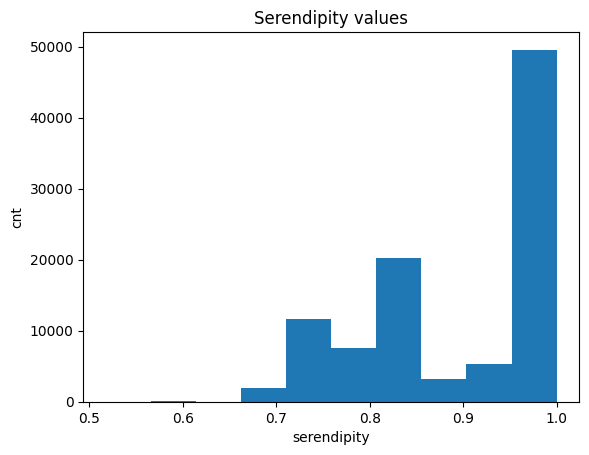

In [183]:
plt.hist(serend_vals)
plt.xlabel("serendipity")
plt.ylabel("cnt")
plt.title("Serendipity values")

#### Categories sampling

In real recommendation systems, it is important to add variety to the final recommendations to get rid of the possibility of users falling into a recommendation bubble. Let's make a batch of diverse recommendations!

In [159]:
def sample_items_by_category(total_preds, item_category, num_samples=3):
    diverse_recs = {}
    category_count = []
    
    for user_id, preds in tqdm(total_preds.items()):
        category_items = defaultdict(list)
        
        for item_id in preds:
            category = item_category.get(item_id)
            if category:
                category_items[category].append(item_id)

        # Save number of categories for each user
        category_count.append(len(category_items))

        # Sample items from each category
        sampled_items = []
        for category, items in category_items.items():
            if len(items) > 0:
                sampled = random.sample(items, min(num_samples, len(items)))
                sampled_items.extend(sampled)
        
        random.shuffle(sampled_items)
        diverse_recs[user_id] = sampled_items
    
    return diverse_recs, category_count

In [161]:
diverse_recs, category_count = sample_items_by_category(total_preds, items_with_categories)

100%|██████████| 99353/99353 [00:09<00:00, 10163.16it/s]


Text(0.5, 1.0, 'Category count by users')

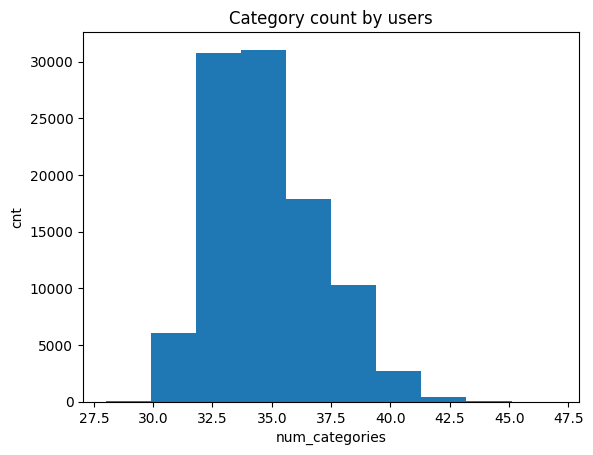

In [162]:
plt.hist(category_count, bins=10)
plt.xlabel("num_categories")
plt.ylabel("cnt")
plt.title("Category count by users")

Now, let's calculate IoU for top10 recommendations to compare with baseline (category-based) recommendations:

In [164]:
top_n = 10

categories = items_data['categories'].unique()
category_to_index = {category: i for i, category in enumerate(categories)}

iou_scores = []

for user in tqdm(ratings['user_id'].unique()):
    rec_item_ids = diverse_recs[user]
    
    rec_categories = set(items_data[items_data['item_id'].isin(rec_item_ids)]['categories'])
    rec_vector = [1 if category in rec_categories else 0 for category in categories]
    
    # Get category-based recommendations (as a baseline)
    user_interacted_item_ids = ratings[ratings['user_id'] == user]['item_id'].unique()
    user_interacted_categories = set(items_data[items_data['item_id'].isin(user_interacted_item_ids)]['categories'])
    baseline_recommendations = items_data[items_data['categories'].isin(user_interacted_categories)]

    if len(baseline_recommendations) > top_n:
        baseline_recommendations = baseline_recommendations.sample(top_n, replace=False)
    baseline_categories = set(baseline_recommendations['categories'])
    
    baseline_vector = [1 if category in baseline_categories else 0 for category in categories]

    # Calculate IoU (Jaccard similarity) between the two vectors
    iou_score = jaccard_score(rec_vector, baseline_vector)
    iou_scores.append(iou_score)

iou_df = pd.DataFrame({'user_id': ratings['user_id'].unique(), 'iou_score': iou_scores})

100%|██████████| 99353/99353 [04:50<00:00, 341.81it/s]


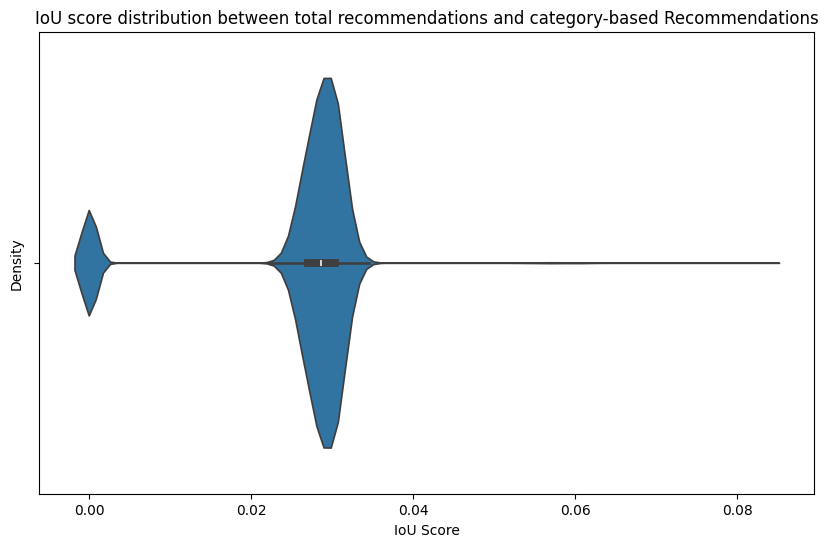

In [166]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=iou_df, x='iou_score')
plt.title("IoU score distribution between total recommendations and category-based Recommendations")
plt.xlabel("IoU Score")
plt.ylabel("Density")
plt.show()